In [1]:
import os
import cv2
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:
def scan_image_directories(base_path):
    """
    Scan directories and create a mapping of images to their metadata
    Filename structure: artist-name_painting-title-YYYY.jpg (YYYY is optional)
    """
    import re
    image_data = []
    
    for style_dir in Path(base_path).iterdir():
        if style_dir.is_dir():
            for img_file in style_dir.iterdir():
                if img_file.suffix.lower() == '.jpg':
                    filename = img_file.stem  # filename without extension
                    
                    # Extract artist name (everything before first underscore)
                    if '_' in filename:
                        artist_name = filename.split('_')[0]
                    else:
                        artist_name = filename  # fallback if no underscore
                    
                    # Extract year using regex (last 4 digits preceded by dash)
                    year_match = re.search(r'-(\d{4})$', filename)
                    image_data.append({
                        'filepath': str(img_file),
                        'filename': filename,
                        'artist': artist_name,
                        'year': year_match.group(1) if year_match else None,
                        'style_directory': style_dir.name,
                        'file_size': img_file.stat().st_size
                    })
    
    return pd.DataFrame(image_data)


In [3]:
def safe_load_image(filepath, target_format='RGB'):
    """
    Safely load images with error handling and format conversion
    """
    try:
        # Try PIL first (better format support)
        img = Image.open(filepath)

        # Convert to RGB if needed
        if img.mode != target_format:
            img = img.convert(target_format)
        img = np.array(img)
        img = img.reshape((-1, 3))
        return np.array(img)

    except Exception as e:
        try:
            # Fallback to OpenCV
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                return img
        except:
            pass

        print(f"Failed to load {filepath}: {e}")
        return None


In [4]:
class ImageBatchProcessor:

    def __init__(self, batch_size=100, cache_samples=True):
        self.batch_size = batch_size
        self.color_samples = [] if cache_samples else None

    def process_batch(self,
                      image_paths):
        """
        Process images in batches to manage memory
        """
        batch_samples = []

        for filepath in image_paths:
            img = safe_load_image(filepath)
            if img is not None:
                batch_samples.append(img)

        return np.vstack(batch_samples) if batch_samples else np.array([])

In [5]:
def preprocess_images_for_palette(image_df,
                                  batch_size=50):
    """
    Complete preprocessing pipeline
    """
    processor = ImageBatchProcessor(batch_size)
    all_samples = []

    # Process in batches
    for i in range(0, len(image_df), batch_size):
        batch_df = image_df.iloc[i:i + batch_size]

        batch_samples = processor.process_batch(batch_df['filepath'].tolist())

        if len(batch_samples) > 0:
            all_samples.append(batch_samples)

    return all_samples

In [20]:
images_data = scan_image_directories('data')
images_data['filepath'][0]

'data/Analytical_Cubism/albert-gleizes_acrobats-1916.jpg'

In [6]:
images_data = scan_image_directories('data')
samples = preprocess_images_for_palette(images_data, batch_size=1)
samples[0].shape

(250200, 3)

In [7]:
def group_samples_with_kmeans(samples,
                              n_clusters=8,
                              random_state=42,
                              normalize=False):

    grouping_result = []

    for sample in samples:
        # Normalize if requested
        processed_sample = sample.copy()
        if normalize and sample.max() > 1:
            processed_sample = sample / 255.0

        # Fit K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=random_state,
                        n_init=10)
        labels = kmeans.fit_predict(processed_sample)

        # Get centroids
        centroids = kmeans.cluster_centers_

        # Convert back to 0-255 range if normalized
        if normalize and sample.max() > 1:
            centroids = centroids * 255.0

        # Count sample per cluster
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_counts = dict(zip(unique_labels, counts))

        grouping_result.append({
            'labels': labels,
            'centroids': centroids,
            'kmeans_model': kmeans,
            'cluster_counts': cluster_counts,
            'n_clusters': n_clusters
        })

    return grouping_result


In [8]:
def group_samples_with_kmedoids(samples_list, n_clusters=8, random_state=42, 
    normalize=False, max_iter=300):
        results = []

        for i, samples in enumerate(samples_list):
            if samples.size == 0:
                continue

            # Normalize if requested
            processed_samples = samples.copy()
            if normalize and samples.max() > 1:
                processed_samples = samples / 255.0

            # Fit K-Medoids
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state, max_iter=max_iter)
            labels = kmedoids.fit_predict(processed_samples)

            # Get medoids (actual data points, not centroids)
            medoids = kmedoids.cluster_centers_
            medoid_indices = kmedoids.medoid_indices_

            # Convert back to 0-255 range if normalized
            if normalize and samples.max() > 1:
                medoids = medoids * 255.0

            # Count samples per cluster
            unique_labels, counts = np.unique(labels, return_counts=True)
            cluster_counts = dict(zip(unique_labels, counts))

            # Calculate inertia (sum of distances to medoids)
            inertia = kmedoids.inertia_

            results.append({
                'labels': labels,
                'medoids': medoids,
                'medoid_indices': medoid_indices,
                'cluster_counts': cluster_counts,
                'inertia': inertia,
                'n_clusters': n_clusters,
                'sample_index': i
            })

        return results

In [9]:
def group_samples_with_meanshift(samples_list, bandwidth=None, quantile=0.08, n_samples=100, bin_seeding=True, normalize=False):
    results = []
    
    for i, samples in enumerate(samples_list):
        if samples.size == 0:
            continue
            
        # Normalize if requested
        processed_samples = samples.copy()
        if normalize and samples.max() > 1:
            processed_samples = samples / 255.0
        
        # Estimate bandwidth if not provided
        if bandwidth is None:
            sample_size = min(n_samples, len(processed_samples))
            sample_indices = np.random.choice(len(processed_samples), sample_size, replace=False)
            bandwidth_est = estimate_bandwidth(processed_samples[sample_indices], quantile=quantile)
        else:
            bandwidth_est = bandwidth
        
        # Fit Mean Shift
        meanshift = MeanShift(bandwidth=bandwidth_est, bin_seeding=bin_seeding)
        labels = meanshift.fit_predict(processed_samples)
        
        # Get cluster centers
        cluster_centers = meanshift.cluster_centers_
        
        # Convert back to 0-255 range if normalized
        if normalize and samples.max() > 1:
            cluster_centers = cluster_centers * 255.0
        
        # Count samples per cluster
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_counts = dict(zip(unique_labels, counts))
        
        # Number of clusters (automatically determined)
        n_clusters_found = len(cluster_centers)
        
        results.append({
            'labels': labels,
            'cluster_centers': cluster_centers,
            'n_clusters': n_clusters_found,
            'cluster_counts': cluster_counts,
            'bandwidth': bandwidth_est,
            'sample_index': i
        })
    
    return results

In [10]:
def group_samples_with_fuzzy_cmeans(samples_list, n_clusters=8, fuzziness=2, max_iter=300, tolerance=1e-4, random_state=42, normalize=False):
    import skfuzzy as fuzz
    
    results = []
    
    for i, samples in enumerate(samples_list):
        if samples.size == 0:
            continue
            
        # Normalize if requested
        processed_samples = samples.copy()
        if normalize and samples.max() > 1:
            processed_samples = samples / 255.0
        
        # Transpose for skfuzzy (features x samples)
        data_transposed = processed_samples.T
        
        # Set random seed for reproducibility
        np.random.seed(random_state)
        
        # Perform Fuzzy C-Means clustering
        cluster_centers, membership_matrix, _, _, objective_function, n_iter, fpc = fuzz.cluster.cmeans(
            data_transposed, 
            n_clusters, 
            fuzziness, 
            error=tolerance, 
            maxiter=max_iter, 
            init=None
        )
        
        # Transpose cluster centers back to original format
        cluster_centers = cluster_centers.T
        
        # Convert back to 0-255 range if normalized
        if normalize and samples.max() > 1:
            cluster_centers = cluster_centers * 255.0
        
        # Get hard cluster labels (highest membership)
        labels = np.argmax(membership_matrix, axis=0)
        
        # Count samples per cluster
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_counts = dict(zip(unique_labels, counts))
        
        results.append({
            'labels': labels,
            'membership_matrix': membership_matrix.T,  # Transpose back to samples x clusters
            'cluster_centers': cluster_centers,
            'cluster_counts': cluster_counts,
            'fuzziness': fuzziness,
            'objective_function': objective_function[-1],  # Final objective value
            'n_iterations': n_iter,
            'fuzzy_partition_coefficient': fpc,
            'n_clusters': n_clusters,
            'sample_index': i
        })
    
    return results

In [11]:
def elbow_plot(X, model, k_min=2, k_max=10, figsize=(10, 6)):
    """
    Generate elbow plot for clustering evaluation
    
    Parameters:
    -----------
    X : numpy.ndarray or list of numpy.ndarray
        Data for clustering. If list, uses first element
    model : str
        Model name ('kmeans', 'kmedoids', 'meanshift', 'fuzzy_cmeans')
    k_min : int, default=2
        Minimum number of clusters to test
    k_max : int, default=10
        Maximum number of clusters to test
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    
    Returns:
    --------
    dict: Dictionary containing:
        - 'k_values': range of k values tested
        - 'inertias': list of inertia/objective values
        - 'optimal_k': suggested optimal k using elbow method
    """
    # Handle list input (take first element)
    if isinstance(X, list):
        data = X[0] if len(X) > 0 else np.array([])
    else:
        data = X
    
    if data.size == 0:
        print("Error: No data provided")
        return None
    
    k_values = range(k_min, k_max + 1)
    inertias = []
    
    print(f"Testing {model} clustering for k = {k_min} to {k_max}...")
    
    for k in k_values:
        try:
            if model.lower() == 'kmeans':
                results = group_samples_with_kmeans([data], n_clusters=k)
                if results:
                    # Calculate inertia manually for kmeans
                    labels = results[0]['labels']
                    centroids = results[0]['centroids']
                    inertia = np.sum([np.sum((data[labels == i] - centroids[i]) ** 2) 
                                    for i in range(k) if np.sum(labels == i) > 0])
                    inertias.append(inertia)
                else:
                    inertias.append(float('inf'))
            
            elif model.lower() == 'kmedoids':
                results = group_samples_with_kmedoids([data], n_clusters=k)
                if results:
                    inertias.append(results[0]['inertia'])
                else:
                    inertias.append(float('inf'))
            
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
                if results:
                    inertias.append(results[0]['objective_function'])
                else:
                    inertias.append(float('inf'))
            
            elif model.lower() == 'meanshift':
                # Mean shift doesn't use k parameter, skip elbow plot
                print("Warning: Mean Shift automatically determines clusters. Elbow plot not applicable.")
                return None
            
            else:
                print(f"Error: Unknown model '{model}'. Available: 'kmeans', 'kmedoids', 'fuzzy_cmeans'")
                return None
                
        except Exception as e:
            print(f"Error at k={k}: {e}")
            inertias.append(float('inf'))
    
    # Find optimal k using elbow method (simple derivative approach)
    if len(inertias) > 2:
        # Calculate differences
        diffs = np.diff(inertias)
        second_diffs = np.diff(diffs)
        
        # Find elbow (maximum curvature)
        if len(second_diffs) > 0:
            optimal_idx = np.argmax(second_diffs) + 2  # +2 because of double diff
            optimal_k = k_values[optimal_idx] if optimal_idx < len(k_values) else k_values[-1]
        else:
            optimal_k = k_values[0]
    else:
        optimal_k = k_values[0]
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Suggested optimal k = {optimal_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia / Objective Function')
    plt.title(f'Elbow Plot for {model.title()} Clustering')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'k_values': list(k_values),
        'inertias': inertias,
        'optimal_k': optimal_k
    }

In [12]:
# Test group_samples_with_meanshift function
# Convert samples to list format if it's a single array

"""
if isinstance(samples, np.ndarray):
    samples_list = [samples]
else:
    samples_list = samples

# Test Mean Shift clustering with different parameters
print("Testing Mean Shift Clustering...")
print("=" * 50)

# Test 1: Default parameters
print("Test 1: Default parameters (auto bandwidth estimation)")
meanshift_results_default = group_samples_with_meanshift(samples_list)

if meanshift_results_default:
    result = meanshift_results_default[0]
    print(f"Number of clusters found: {result['n_clusters']}")
    print(f"Bandwidth used: {result['bandwidth']:.6f}")
    print(f"Cluster counts: {result['cluster_counts']}")
    print()

# Test 2: Different quantile for bandwidth estimation
print("Test 2: Different quantile (0.15) for bandwidth estimation")
meanshift_results_q15 = group_samples_with_meanshift(samples_list, quantile=0.15)

if meanshift_results_q15:
    result = meanshift_results_q15[0]
    print(f"Number of clusters found: {result['n_clusters']}")
    print(f"Bandwidth used: {result['bandwidth']:.6f}")
    print(f"Cluster counts: {result['cluster_counts']}")
    print()

# Test 3: Fixed bandwidth
print("Test 3: Fixed bandwidth (0.1)")
meanshift_results_fixed = group_samples_with_meanshift(samples_list, bandwidth=0.1)

if meanshift_results_fixed:
    result = meanshift_results_fixed[0]
    print(f"Number of clusters found: {result['n_clusters']}")
    print(f"Bandwidth used: {result['bandwidth']:.6f}")
    print(f"Cluster counts: {result['cluster_counts']}")
    print()

# Test 4: Normalized data
print("Test 4: With normalized data")
meanshift_results_norm = group_samples_with_meanshift(samples_list, normalize=True, quantile=0.08)

if meanshift_results_norm:
    result = meanshift_results_norm[0]
    print(f"Number of clusters found: {result['n_clusters']}")
    print(f"Bandwidth used: {result['bandwidth']:.6f}")
    print(f"Cluster counts: {result['cluster_counts']}")
    print()

# Compare results
print("Comparison Summary:")
print("=" * 50)
test_names = ["Default", "Quantile 0.15", "Fixed BW 0.1", "Normalized"]
test_results = [meanshift_results_default, meanshift_results_q15, 
                meanshift_results_fixed, meanshift_results_norm]

for name, results in zip(test_names, test_results):
    if results:
        result = results[0]
        print(f"{name:15} | Clusters: {result['n_clusters']:2d} | Bandwidth: {result['bandwidth']:.6f}")
    else:
        print(f"{name:15} | Failed")

# Display color palette from default result
if meanshift_results_default:
    result = meanshift_results_default[0]
    palette = result['cluster_centers']
    
    # Convert to 0-255 range if needed
    if palette.max() <= 1:
        palette_display = (palette * 255).astype(int)
    else:
        palette_display = palette.astype(int)
    
    print(f"\nColor palette from default Mean Shift ({result['n_clusters']} colors):")
    for i, color in enumerate(palette_display):
        print(f"Cluster {i}: RGB{tuple(color)}")

"""

'\nif isinstance(samples, np.ndarray):\n    samples_list = [samples]\nelse:\n    samples_list = samples\n\n# Test Mean Shift clustering with different parameters\nprint("Testing Mean Shift Clustering...")\nprint("=" * 50)\n\n# Test 1: Default parameters\nprint("Test 1: Default parameters (auto bandwidth estimation)")\nmeanshift_results_default = group_samples_with_meanshift(samples_list)\n\nif meanshift_results_default:\n    result = meanshift_results_default[0]\n    print(f"Number of clusters found: {result[\'n_clusters\']}")\n    print(f"Bandwidth used: {result[\'bandwidth\']:.6f}")\n    print(f"Cluster counts: {result[\'cluster_counts\']}")\n    print()\n\n# Test 2: Different quantile for bandwidth estimation\nprint("Test 2: Different quantile (0.15) for bandwidth estimation")\nmeanshift_results_q15 = group_samples_with_meanshift(samples_list, quantile=0.15)\n\nif meanshift_results_q15:\n    result = meanshift_results_q15[0]\n    print(f"Number of clusters found: {result[\'n_cluster

Testing kmeans clustering for k = 2 to 6...


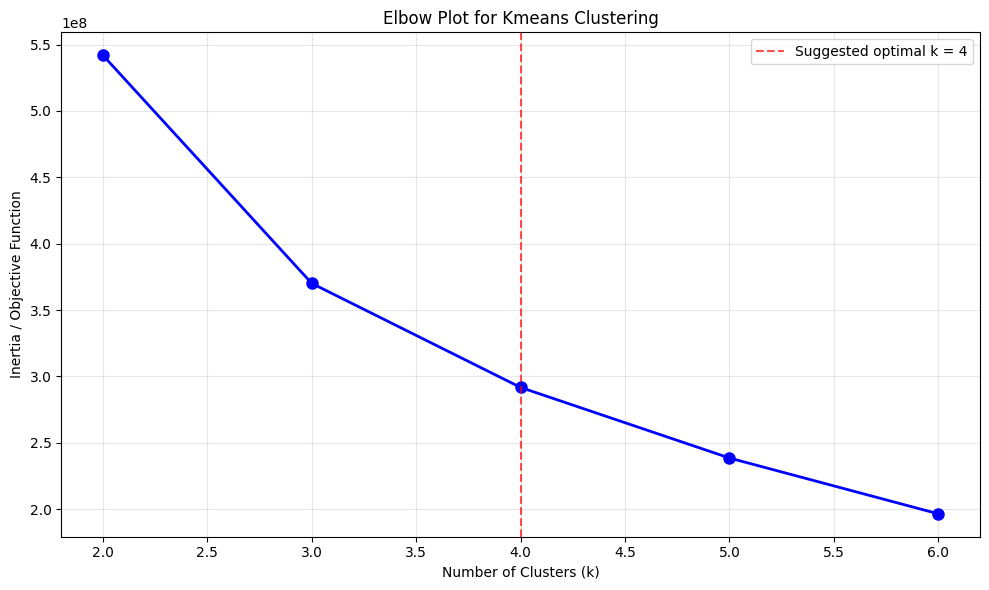

In [13]:
elbow_result = elbow_plot(samples, 'kmeans', k_min=2, k_max=6)

In [13]:
elbow_plot(samples, 'kmedoids', k_min=2, k_max=6)

Testing kmedoids clustering for k = 2 to 6...


: 

Testing fuzzy_cmeans clustering for k = 2 to 6...


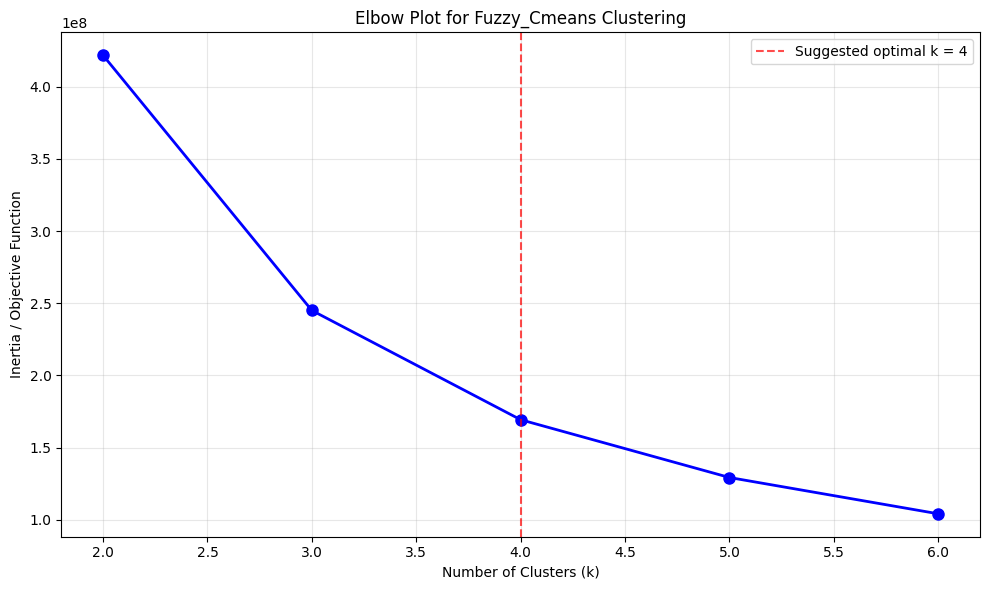

{'k_values': [2, 3, 4, 5, 6],
 'inertias': [421796346.7532075,
  245052933.1786871,
  169361734.40678555,
  129338245.86825186,
  104202914.96650468],
 'optimal_k': 4}

In [14]:
elbow_plot(samples, 'fuzzy_cmeans', k_min=2, k_max=6)

In [15]:
def silhouette_plot(X, model, k_min=2, k_max=10, figsize=(10, 6)):
    """
    Generate silhouette plot for clustering evaluation
    
    Parameters:
    -----------
    X : numpy.ndarray or list of numpy.ndarray
        Data for clustering. If list, uses first element
    model : str
        Model name ('kmeans', 'kmedoids', 'meanshift', 'fuzzy_cmeans')
    k_min : int, default=2
        Minimum number of clusters to test
    k_max : int, default=10
        Maximum number of clusters to test
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    
    Returns:
    --------
    dict: Dictionary containing:
        - 'k_values': range of k values tested
        - 'silhouette_scores': list of silhouette scores
        - 'optimal_k': suggested optimal k (highest silhouette score)
    """
    from sklearn.metrics import silhouette_score
    
    # Handle list input (take first element)
    if isinstance(X, list):
        data = X[0] if len(X) > 0 else np.array([])
    else:
        data = X
    
    if data.size == 0:
        print("Error: No data provided")
        return None
    
    if len(data) < k_max:
        print(f"Warning: Data has only {len(data)} samples, reducing k_max to {len(data)-1}")
        k_max = min(k_max, len(data) - 1)
        k_min = min(k_min, k_max)
    
    k_values = range(k_min, k_max + 1)
    silhouette_scores = []
    
    print(f"Testing {model} clustering silhouette scores for k = {k_min} to {k_max}...")
    
    for k in k_values:
        try:
            if model.lower() == 'kmeans':
                results = group_samples_with_kmeans([data], n_clusters=k)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)  # Invalid clustering
            
            elif model.lower() == 'kmedoids':
                results = group_samples_with_kmedoids([data], n_clusters=k)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)
            
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)
            
            elif model.lower() == 'meanshift':
                # For Mean Shift, we can test different bandwidth values
                # Use bandwidth as a proxy for k (smaller bandwidth = more clusters)
                base_bandwidth = 0.5 / k  # Inverse relationship
                results = group_samples_with_meanshift([data], bandwidth=base_bandwidth)
                if results and len(np.unique(results[0]['labels'])) > 1:
                    labels = results[0]['labels']
                    actual_k = results[0]['n_clusters']
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                    print(f"k={k} (bandwidth={base_bandwidth:.4f}) -> {actual_k} clusters, silhouette={score:.3f}")
                else:
                    silhouette_scores.append(-1)
            
            else:
                print(f"Error: Unknown model '{model}'. Available: 'kmeans', 'kmedoids', 'fuzzy_cmeans', 'meanshift'")
                return None
                
        except Exception as e:
            print(f"Error at k={k}: {e}")
            silhouette_scores.append(-1)
    
    # Find optimal k (highest silhouette score)
    valid_scores = [s for s in silhouette_scores if s > -1]
    if valid_scores:
        optimal_idx = np.argmax(silhouette_scores)
        optimal_k = k_values[optimal_idx]
        max_score = silhouette_scores[optimal_idx]
    else:
        optimal_k = k_values[0]
        max_score = -1
    
    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(k_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
    
    if max_score > -1:
        plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
                    label=f'Optimal k = {optimal_k} (score = {max_score:.3f})')
        plt.axhline(y=max_score, color='red', linestyle=':', alpha=0.5)
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Analysis for {model.title()} Clustering')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add score annotations
    for i, (k, score) in enumerate(zip(k_values, silhouette_scores)):
        if score > -1:
            plt.annotate(f'{score:.3f}', (k, score), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSilhouette Score Summary for {model.title()}:")
    print("=" * 40)
    for k, score in zip(k_values, silhouette_scores):
        status = "✓" if score > 0.5 else "○" if score > 0.3 else "✗" if score > -1 else "ERROR"
        print(f"k={k:2d}: {score:6.3f} {status}")
    
    return {
        'k_values': list(k_values),
        'silhouette_scores': silhouette_scores,
        'optimal_k': optimal_k,
        'max_score': max_score
    }

In [16]:
def silhouette_analysis(X, model, k_min=2, k_max=6, figsize=(15, 10)):
    """
    Generate detailed silhouette analysis plots showing individual sample scores
    
    Parameters:
    -----------
    X : numpy.ndarray or list of numpy.ndarray
        Data for clustering. If list, uses first element
    model : str
        Model name ('kmeans', 'kmedoids', 'fuzzy_cmeans')
    k_min : int, default=2
        Minimum number of clusters to test
    k_max : int, default=6
        Maximum number of clusters to test (keep reasonable for visualization)
    figsize : tuple, default=(15, 10)
        Figure size for the plot
    
    Returns:
    --------
    dict: Dictionary containing detailed silhouette analysis results
    """
    from sklearn.metrics import silhouette_score, silhouette_samples
    import matplotlib.cm as cm
    
    # Handle list input (take first element)
    if isinstance(X, list):
        data = X[0] if len(X) > 0 else np.array([])
    else:
        data = X
    
    if data.size == 0:
        print("Error: No data provided")
        return None
    
    if len(data) < k_max:
        print(f"Warning: Data has only {len(data)} samples, reducing k_max to {len(data)-1}")
        k_max = min(k_max, len(data) - 1)
        k_min = min(k_min, k_max)
    
    if k_max - k_min > 8:
        print("Warning: Too many k values for visualization. Consider reducing range.")
        k_max = k_min + 8
    
    k_values = range(k_min, k_max + 1)
    n_plots = len(k_values)
    
    # Calculate subplot layout
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    results = {}
    overall_scores = []
    
    print(f"Generating detailed silhouette analysis for {model} (k = {k_min} to {k_max})...")
    
    for idx, k in enumerate(k_values):
        try:
            # Get clustering results
            if model.lower() == 'kmeans':
                cluster_results = group_samples_with_kmeans([data], n_clusters=k)
            elif model.lower() == 'kmedoids':
                cluster_results = group_samples_with_kmedoids([data], n_clusters=k)
            elif model.lower() == 'fuzzy_cmeans' or model.lower() == 'fuzzy':
                cluster_results = group_samples_with_fuzzy_cmeans([data], n_clusters=k)
            elif model.lower() == 'meanshift':
                print("Note: Mean Shift automatically determines clusters. Using fixed bandwidth approach.")
                base_bandwidth = 0.5 / k
                cluster_results = group_samples_with_meanshift([data], bandwidth=base_bandwidth)
                if cluster_results:
                    actual_k = cluster_results[0]['n_clusters']
                    if actual_k != k:
                        print(f"Mean Shift with bandwidth {base_bandwidth:.4f} found {actual_k} clusters (expected {k})")
            else:
                print(f"Error: Unknown model '{model}'")
                return None
            
            if not cluster_results or len(cluster_results) == 0:
                print(f"No results for k={k}")
                continue
                
            labels = cluster_results[0]['labels']
            
            # Skip if only one cluster
            if len(np.unique(labels)) <= 1:
                print(f"Only one cluster found for k={k}, skipping")
                continue
            
            # Calculate silhouette scores
            sample_silhouette_values = silhouette_samples(data, labels)
            silhouette_avg = silhouette_score(data, labels)
            overall_scores.append(silhouette_avg)
            
            # Create subplot
            ax = axes[idx] if idx < len(axes) else None
            if ax is None:
                continue
                
            y_lower = 10
            colors = cm.nipy_spectral(np.linspace(0, 1, k))
            
            cluster_silhouette_avgs = []
            
            for i in range(k):
                # Get silhouette scores for samples in cluster i
                cluster_silhouette_values = sample_silhouette_values[labels == i]
                
                if len(cluster_silhouette_values) == 0:
                    continue
                    
                cluster_silhouette_avgs.append(np.mean(cluster_silhouette_values))
                cluster_silhouette_values.sort()
                
                size_cluster_i = cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                
                color = colors[i]
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                               0, cluster_silhouette_values,
                               facecolor=color, edgecolor=color, alpha=0.7)
                
                # Label the silhouette plots with cluster numbers at the middle
                ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10
            
            ax.set_xlabel('Silhouette Score')
            ax.set_ylabel('Cluster Label')
            ax.set_title(f'{model.title()}: k={k}\nAvg Score: {silhouette_avg:.3f}')
            
            # Add vertical line for average silhouette score
            ax.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.8, linewidth=2)
            
            # Set x-axis limits
            ax.set_xlim([-0.1, 1])
            ax.set_ylim([0, len(data) + (k + 1) * 10])
            
            # Store results
            results[k] = {
                'labels': labels,
                'sample_silhouette_values': sample_silhouette_values,
                'silhouette_avg': silhouette_avg,
                'cluster_silhouette_avgs': cluster_silhouette_avgs,
                'n_clusters': len(np.unique(labels))
            }
            
        except Exception as e:
            print(f"Error processing k={k}: {e}")
            continue
    
    # Hide empty subplots
    for idx in range(len(k_values), len(axes)):
        if idx < len(axes):
            axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSilhouette Analysis Summary for {model.title()}:")
    print("=" * 50)
    print("k  | Avg Score | Cluster Scores")
    print("-" * 50)
    
    best_k = None
    best_score = -1
    
    for k in k_values:
        if k in results:
            result = results[k]
            avg_score = result['silhouette_avg']
            cluster_scores = result['cluster_silhouette_avgs']
            
            if avg_score > best_score:
                best_score = avg_score
                best_k = k
            
            cluster_scores_str = ', '.join([f'{score:.3f}' for score in cluster_scores])
            status = "✓" if avg_score > 0.5 else "○" if avg_score > 0.3 else "✗"
            print(f"{k:2d} | {avg_score:8.3f} | [{cluster_scores_str}] {status}")
    
    if best_k:
        print(f"\nRecommended k: {best_k} (score: {best_score:.3f})")
    
    return results

In [17]:
def palette_plot(clustering_results, model_name=None, figsize=(12, 8), show_counts=True, sort_by_frequency=True):
    """
    Generate color palette plots from clustering results
    
    Parameters:
    -----------
    clustering_results : list or dict
        Results from any clustering function (kmeans, kmedoids, meanshift, fuzzy_cmeans)
        Can be a single result dict or list of results
    model_name : str, optional
        Name of the model for plot title. If None, will try to infer from results
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    show_counts : bool, default=True
        Whether to show sample counts for each color
    sort_by_frequency : bool, default=True
        Whether to sort colors by frequency (most common first)
    
    Returns:
    --------
    dict: Dictionary containing palette information for each sample
    """
    import matplotlib.patches as mpatches
    
    # Handle different input formats
    if isinstance(clustering_results, dict):
        # Single result
        results_list = [clustering_results]
    elif isinstance(clustering_results, list):
        if len(clustering_results) == 0:
            print("Error: Empty results list")
            return None
        results_list = clustering_results
    else:
        print("Error: Invalid clustering_results format")
        return None
    
    n_samples = len(results_list)
    
    # Determine model name if not provided
    if model_name is None:
        if 'centroids' in results_list[0]:
            model_name = 'K-Means'
        elif 'medoids' in results_list[0]:
            model_name = 'K-Medoids'
        elif 'cluster_centers' in results_list[0] and 'bandwidth' in results_list[0]:
            model_name = 'Mean Shift'
        elif 'membership_matrix' in results_list[0]:
            model_name = 'Fuzzy C-Means'
        else:
            model_name = 'Unknown'
    
    # Calculate subplot layout
    cols = min(3, n_samples)
    rows = (n_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_samples == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = axes
    elif rows > 1 and cols == 1:
        axes = axes
    else:
        axes = axes.flatten() if n_samples > 1 else [axes]
    
    palette_info = {}
    
    for sample_idx, result in enumerate(results_list):
        try:
            # Extract colors based on model type
            if 'centroids' in result:
                # K-Means
                colors = result['centroids']
                cluster_counts = result['cluster_counts']
                method = 'centroids'
            elif 'medoids' in result:
                # K-Medoids
                colors = result['medoids']
                cluster_counts = result['cluster_counts']
                method = 'medoids'
            elif 'cluster_centers' in result:
                # Mean Shift or Fuzzy C-Means
                colors = result['cluster_centers']
                cluster_counts = result['cluster_counts']
                method = 'centers'
            else:
                print(f"Error: Cannot extract colors from sample {sample_idx}")
                continue
            
            # Ensure colors are in 0-255 range
            if colors.max() <= 1.0:
                colors_display = (colors * 255).astype(int)
            else:
                colors_display = colors.astype(int)
            
            # Create color-count pairs for sorting
            color_data = []
            for i, color in enumerate(colors_display):
                count = cluster_counts.get(i, 0)
                color_data.append((color, count, i))
            
            # Sort by frequency if requested
            if sort_by_frequency:
                color_data.sort(key=lambda x: x[1], reverse=True)
            
            # Get current subplot
            ax = axes[sample_idx] if sample_idx < len(axes) else None
            if ax is None:
                continue
            
            # Create palette visualization
            n_colors = len(color_data)
            for i, (color, count, original_idx) in enumerate(color_data):
                # Create color rectangle
                rect = mpatches.Rectangle((i, 0), 1, 1, color=color / 255.0)
                ax.add_patch(rect)
                
                # Add count annotation if requested
                if show_counts:
                    ax.text(i + 0.5, 0.5, f'{count}', 
                           ha='center', va='center', 
                           fontsize=10, fontweight='bold',
                           color='white' if np.mean(color) < 128 else 'black')
                
                # Add RGB values at the bottom
                rgb_text = f'RGB({color[0]},{color[1]},{color[2]})'
                ax.text(i + 0.5, -0.1, rgb_text, 
                       ha='center', va='top', fontsize=8, rotation=45)
            
            # Configure subplot
            ax.set_xlim(0, n_colors)
            ax.set_ylim(-0.3, 1)
            ax.set_aspect('equal')
            ax.axis('off')
            
            # Add title with sample info
            sample_info = f'Sample {sample_idx + 1}'
            if 'n_clusters' in result:
                sample_info += f' ({result["n_clusters"]} colors)'
            elif n_colors > 0:
                sample_info += f' ({n_colors} colors)'
            
            # Add bandwidth info for Mean Shift
            if 'bandwidth' in result:
                sample_info += f'\nBandwidth: {result["bandwidth"]:.4f}'
            
            ax.set_title(sample_info, fontsize=12, pad=20)
            
            # Store palette information
            palette_info[sample_idx] = {
                'colors_rgb': [tuple(color) for color, _, _ in color_data],
                'colors_hex': ['#%02x%02x%02x' % tuple(color) for color, _, _ in color_data],
                'counts': [count for _, count, _ in color_data],
                'original_indices': [orig_idx for _, _, orig_idx in color_data],
                'total_samples': sum(cluster_counts.values()),
                'method': method
            }
            
        except Exception as e:
            print(f"Error processing sample {sample_idx}: {e}")
            continue
    
    # Hide empty subplots
    for idx in range(n_samples, len(axes)):
        if idx < len(axes):
            axes[idx].set_visible(False)
    
    # Main title
    fig.suptitle(f'{model_name} Color Palettes', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{model_name} Palette Summary:")
    print("=" * 50)
    
    for sample_idx, info in palette_info.items():
        print(f"\nSample {sample_idx + 1}:")
        print(f"  Method: {info['method']}")
        print(f"  Total samples: {info['total_samples']}")
        print(f"  Number of colors: {len(info['colors_rgb'])}")
        
        if show_counts:
            print("  Color breakdown:")
            for i, (rgb, count, hex_val) in enumerate(zip(info['colors_rgb'], info['counts'], info['colors_hex'])):
                percentage = (count / info['total_samples']) * 100
                print(f"    Color {i+1}: {rgb} ({hex_val}) - {count} samples ({percentage:.1f}%)")
    
    return palette_info

In [18]:
silhouette_result = silhouette_plot(samples, 'kmeans', k_min=2, k_max=10)

Testing kmeans clustering silhouette scores for k = 2 to 10...


KeyboardInterrupt: 

Testing kmedoids clustering silhouette scores for k = 3 to 8...


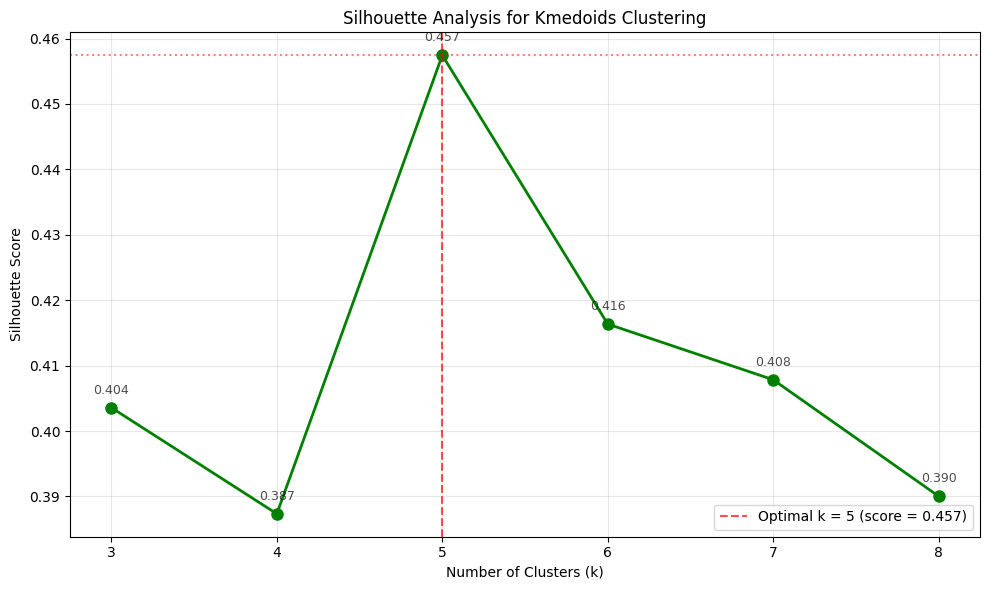


Silhouette Score Summary for Kmedoids:
k= 3:  0.404 ○
k= 4:  0.387 ○
k= 5:  0.457 ○
k= 6:  0.416 ○
k= 7:  0.408 ○
k= 8:  0.390 ○
Testing fuzzy_cmeans clustering silhouette scores for k = 2 to 12...


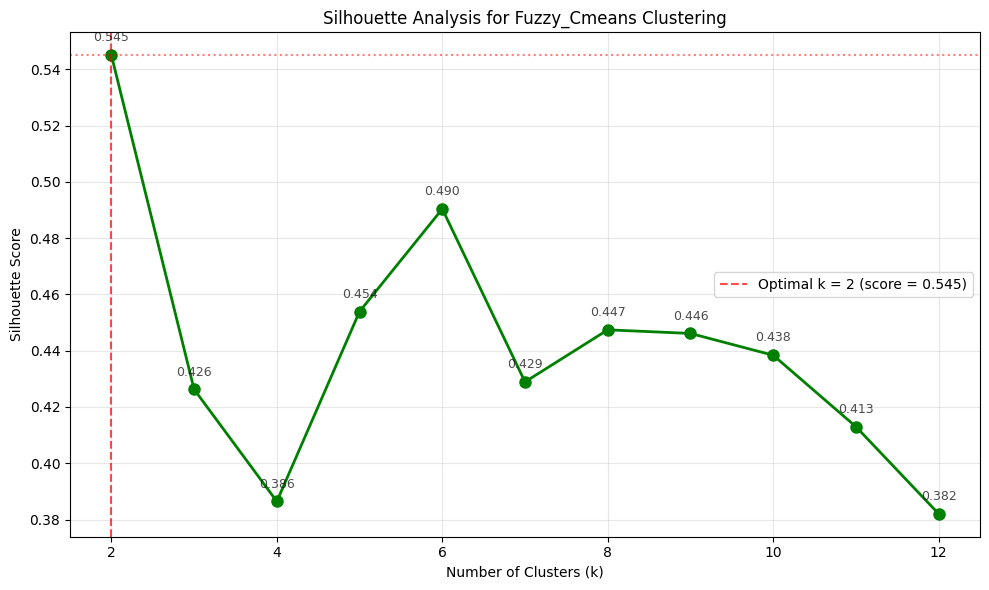


Silhouette Score Summary for Fuzzy_Cmeans:
k= 2:  0.545 ✓
k= 3:  0.426 ○
k= 4:  0.386 ○
k= 5:  0.454 ○
k= 6:  0.490 ○
k= 7:  0.429 ○
k= 8:  0.447 ○
k= 9:  0.446 ○
k=10:  0.438 ○
k=11:  0.413 ○
k=12:  0.382 ○


{'k_values': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'silhouette_scores': [0.5449985106915464,
  0.4262505551903251,
  0.3864309378628247,
  0.45392455768599066,
  0.49038750722433977,
  0.4289113405403738,
  0.4474179249263063,
  0.4461374330418778,
  0.4383942704707844,
  0.41299995599329814,
  0.3820380756629475],
 'optimal_k': 2,
 'max_score': 0.5449985106915464}

In [233]:
# Test other models
silhouette_plot(samples, 'kmedoids', k_min=3, k_max=8)
silhouette_plot(samples, 'fuzzy_cmeans', k_min=2, k_max=12)

Generating detailed silhouette analysis for kmeans (k = 2 to 6)...


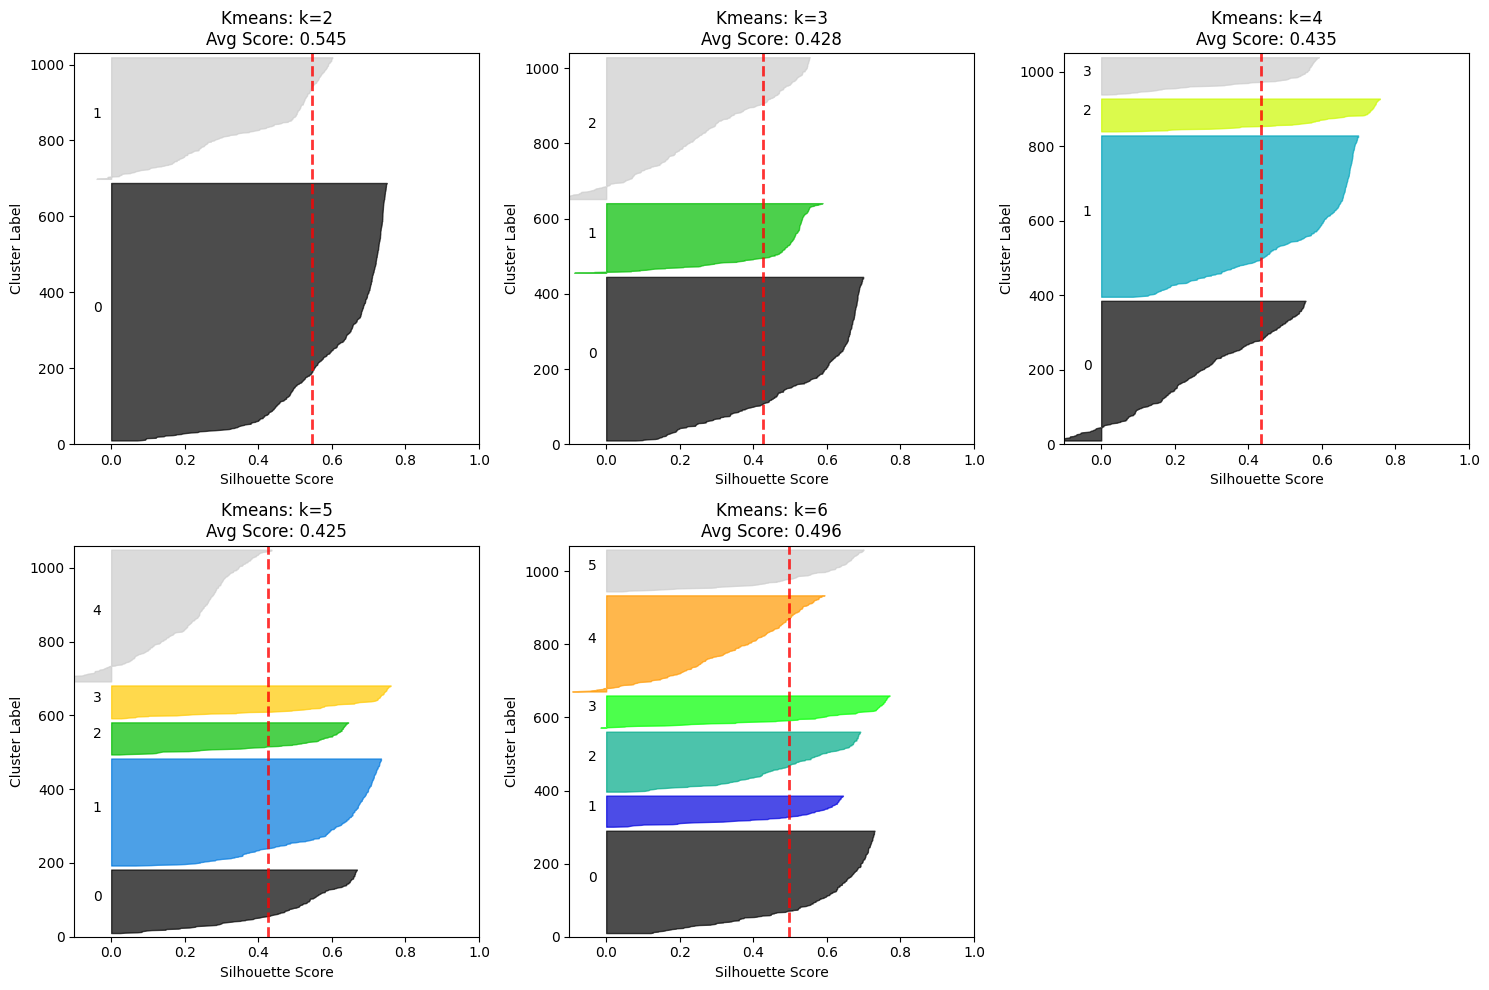


Silhouette Analysis Summary for Kmeans:
k  | Avg Score | Cluster Scores
--------------------------------------------------
 2 |    0.545 | [0.615, 0.397] ✓
 3 |    0.428 | [0.541, 0.454, 0.283] ○
 4 |    0.435 | [0.272, 0.540, 0.609, 0.436] ○
 5 |    0.425 | [0.489, 0.598, 0.497, 0.576, 0.198] ○
 6 |    0.496 | [0.583, 0.494, 0.500, 0.591, 0.351, 0.539] ○

Recommended k: 2 (score: 0.545)
Generating detailed silhouette analysis for kmedoids (k = 2 to 5)...


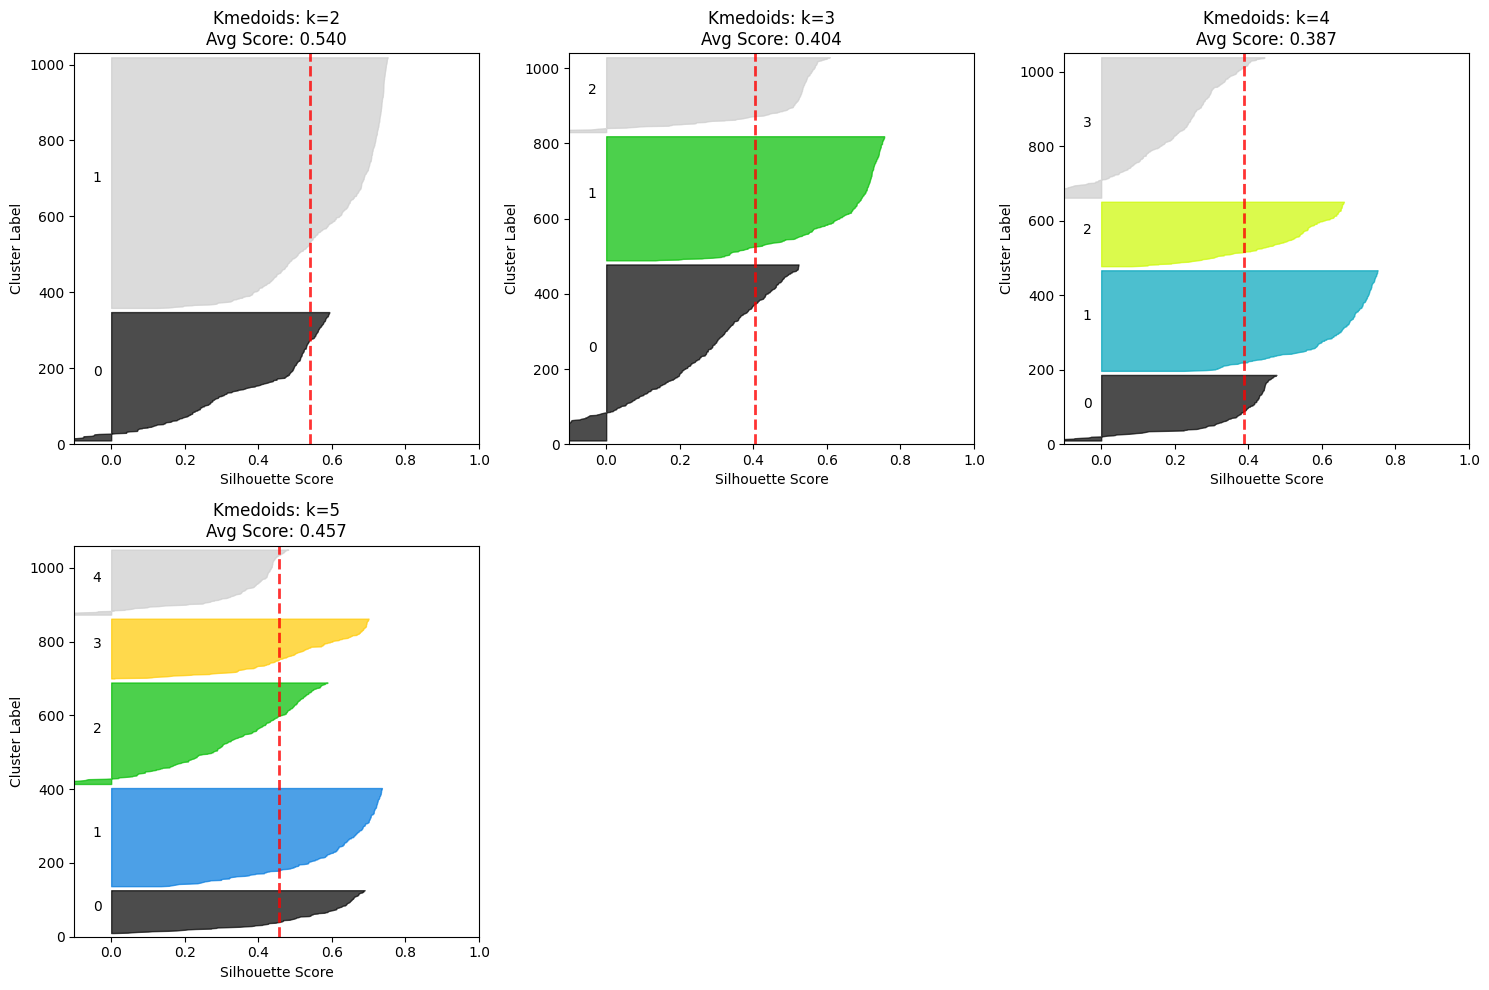


Silhouette Analysis Summary for Kmedoids:
k  | Avg Score | Cluster Scores
--------------------------------------------------
 2 |    0.540 | [0.379, 0.623] ✓
 3 |    0.404 | [0.223, 0.630, 0.452] ○
 4 |    0.387 | [0.337, 0.630, 0.498, 0.186] ○
 5 |    0.457 | [0.520, 0.599, 0.336, 0.518, 0.335] ○

Recommended k: 2 (score: 0.540)
Generating detailed silhouette analysis for fuzzy_cmeans (k = 3 to 7)...


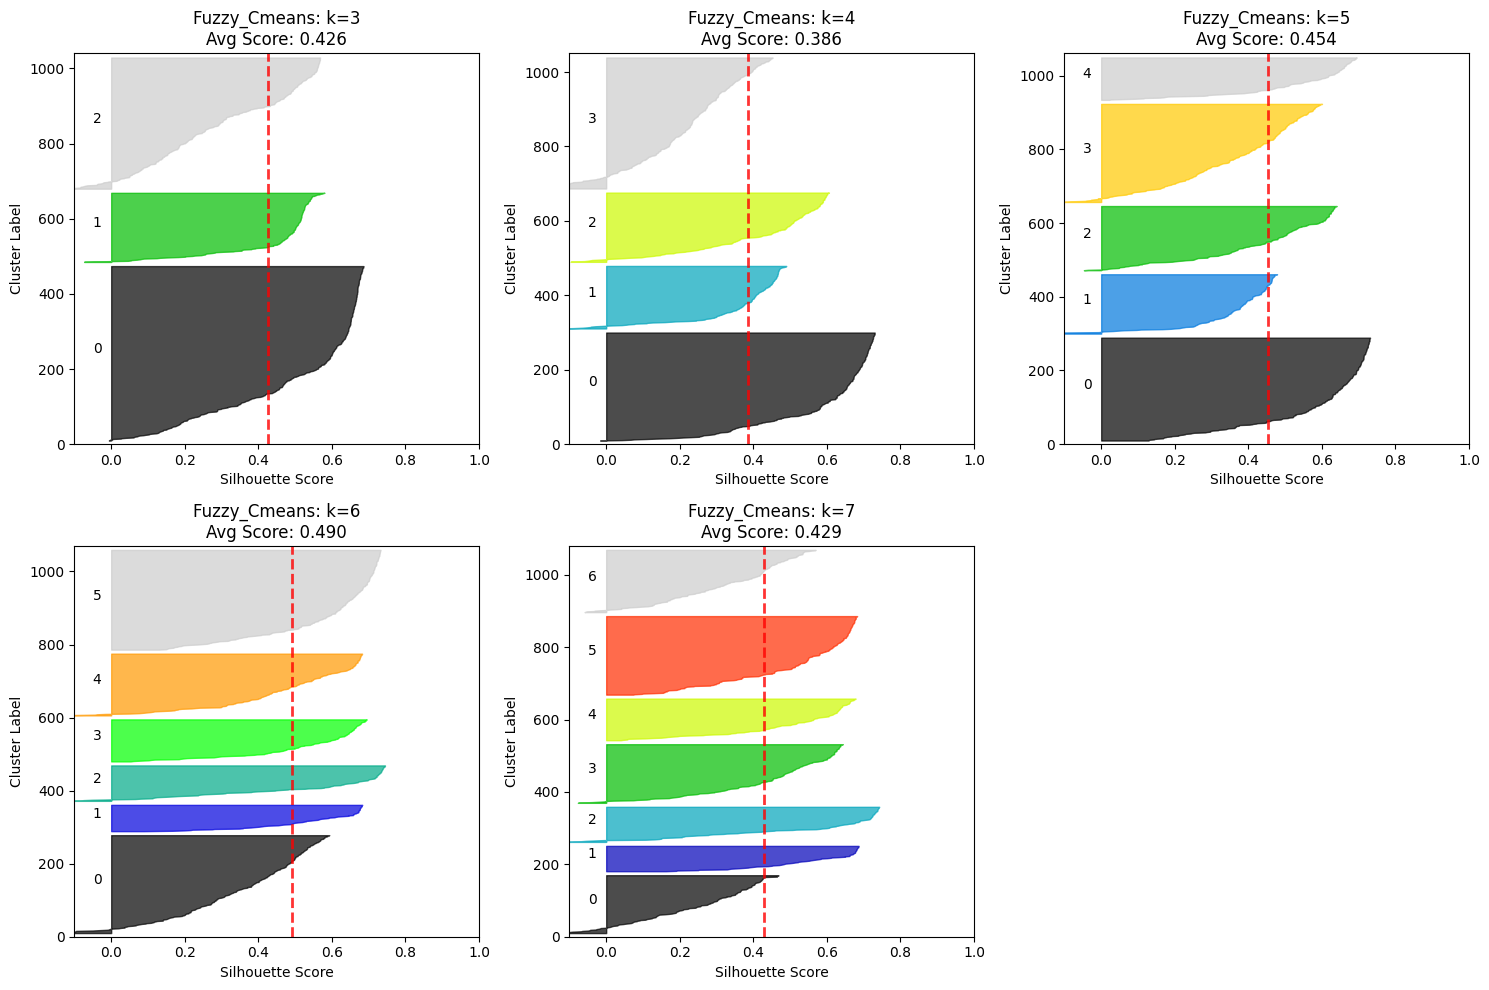


Silhouette Analysis Summary for Fuzzy_Cmeans:
k  | Avg Score | Cluster Scores
--------------------------------------------------
 3 |    0.426 | [0.511, 0.446, 0.303] ○
 4 |    0.386 | [0.591, 0.360, 0.420, 0.213] ○
 5 |    0.454 | [0.586, 0.354, 0.431, 0.358, 0.530] ○
 6 |    0.490 | [0.349, 0.545, 0.533, 0.532, 0.475, 0.591] ○
 7 |    0.429 | [0.237, 0.551, 0.529, 0.446, 0.501, 0.516, 0.328] ○

Recommended k: 6 (score: 0.490)


{3: {'labels': array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2,
         0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2,
         2, 0, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0,
         2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 2,
         0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0,
         2, 2, 0, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2,
         0, 0, 2, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0,
         2, 2, 2, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0,
         1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0,
         2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0,
         0, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2,
         2, 2, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0,
         0, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1,
         0, 

In [236]:
analysis_results = silhouette_analysis(samples, 'kmeans', k_min=2, k_max=6)

# Compare different models
silhouette_analysis(samples, 'kmedoids', k_min=2, k_max=5)
silhouette_analysis(samples, 'fuzzy_cmeans', k_min=3, k_max=7)

In [242]:
def palette_plot(clustering_results, model_name=None, figsize=(12, 8), show_counts=True, 
sort_by_frequency=True):
    """
    Generate color palette plots from clustering results
    
    Parameters:
    -----------
    clustering_results : list or dict
        Results from any clustering function (kmeans, kmedoids, meanshift, fuzzy_cmeans)
        Can be a single result dict or list of results
    model_name : str, optional
        Name of the model for plot title. If None, will try to infer from results
    figsize : tuple, default=(12, 8)
        Figure size for the plot
    show_counts : bool, default=True
        Whether to show sample counts for each color
    sort_by_frequency : bool, default=True
        Whether to sort colors by frequency (most common first)
    
    Returns:
    --------
    dict: Dictionary containing palette information for each sample
    """
    import matplotlib.patches as mpatches

    # Handle different input formats
    if isinstance(clustering_results, dict):
        # Single result
        results_list = [clustering_results]
    elif isinstance(clustering_results, list):
        if len(clustering_results) == 0:
            print("Error: Empty results list")
            return None
        results_list = clustering_results
    else:
        print("Error: Invalid clustering_results format")
        return None

    n_samples = len(results_list)

    # Determine model name if not provided
    if model_name is None:
        if 'centroids' in results_list[0]:
            model_name = 'K-Means'
        elif 'medoids' in results_list[0]:
            model_name = 'K-Medoids'
        elif 'cluster_centers' in results_list[0] and 'bandwidth' in results_list[0]:
            model_name = 'Mean Shift'
        elif 'membership_matrix' in results_list[0]:
            model_name = 'Fuzzy C-Means'
        else:
            model_name = 'Unknown'

    # Calculate subplot layout
    cols = min(3, n_samples)
    rows = (n_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_samples == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = axes
    elif rows > 1 and cols == 1:
        axes = axes
    else:
        axes = axes.flatten() if n_samples > 1 else [axes]

    palette_info = {}

    for sample_idx, result in enumerate(results_list):
        try:
            # Extract colors based on model type
            if 'centroids' in result:
                # K-Means
                colors = result['centroids']
                cluster_counts = result['cluster_counts']
                method = 'centroids'
            elif 'medoids' in result:
                # K-Medoids
                colors = result['medoids']
                cluster_counts = result['cluster_counts']
                method = 'medoids'
            elif 'cluster_centers' in result:
                # Mean Shift or Fuzzy C-Means
                colors = result['cluster_centers']
                cluster_counts = result['cluster_counts']
                method = 'centers'
            else:
                print(f"Error: Cannot extract colors from sample {sample_idx}")
                continue

            # Ensure colors are in 0-255 range
            if colors.max() <= 1.0:
                colors_display = (colors * 255).astype(int)
            else:
                colors_display = colors.astype(int)

            # Create color-count pairs for sorting
            color_data = []
            for i, color in enumerate(colors_display):
                count = cluster_counts.get(i, 0)
                color_data.append((color, count, i))

            # Sort by frequency if requested
            if sort_by_frequency:
                color_data.sort(key=lambda x: x[1], reverse=True)

            # Get current subplot
            ax = axes[sample_idx] if sample_idx < len(axes) else None
            if ax is None:
                continue

            # Create palette visualization
            n_colors = len(color_data)
            for i, (color, count, original_idx) in enumerate(color_data):
                # Create color rectangle
                rect = mpatches.Rectangle((i, 0), 1, 1, color=color / 255.0)
                ax.add_patch(rect)

                # Add count annotation if requested
                if show_counts:
                    ax.text(i + 0.5, 0.5, f'{count}',
                            ha='center', va='center',
                            fontsize=10, fontweight='bold',
                            color='white' if np.mean(color) < 128 else 'black')

                # Add RGB values at the bottom
                rgb_text = f'RGB({color[0]},{color[1]},{color[2]})'
                ax.text(i + 0.5, -0.1, rgb_text,
                        ha='center', va='top', fontsize=8, rotation=45)

            # Configure subplot
            ax.set_xlim(0, n_colors)
            ax.set_ylim(-0.3, 1)
            ax.set_aspect('equal')
            ax.axis('off')

            # Add title with sample info
            sample_info = f'Sample {sample_idx + 1}'
            if 'n_clusters' in result:
                sample_info += f' ({result["n_clusters"]} colors)'
            elif n_colors > 0:
                sample_info += f' ({n_colors} colors)'

            # Add bandwidth info for Mean Shift
            if 'bandwidth' in result:
                sample_info += f'\nBandwidth: {result["bandwidth"]:.4f}'

            ax.set_title(sample_info, fontsize=12, pad=20)

            # Store palette information
            palette_info[sample_idx] = {
                'colors_rgb': [tuple(color) for color, _, _ in color_data],
                'colors_hex': ['#%02x%02x%02x' % tuple(color) for color, _, _ in color_data],
                'counts': [count for _, count, _ in color_data],
                'original_indices': [orig_idx for _, _, orig_idx in color_data],
                'total_samples': sum(cluster_counts.values()),
                'method': method
            }

        except Exception as e:
            print(f"Error processing sample {sample_idx}: {e}")
            continue

    # Hide empty subplots
    for idx in range(n_samples, len(axes)):
        if idx < len(axes):
            axes[idx].set_visible(False)

    # Main title
    fig.suptitle(f'{model_name} Color Palettes', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{model_name} Palette Summary:")
    print("=" * 50)

    for sample_idx, info in palette_info.items():
        print(f"\nSample {sample_idx + 1}:")
        print(f"  Method: {info['method']}")
        print(f"  Total samples: {info['total_samples']}")
        print(f"  Number of colors: {len(info['colors_rgb'])}")

        if show_counts:
            print("  Color breakdown:")
            for i, (rgb, count, hex_val) in enumerate(zip(info['colors_rgb'], info['counts'], info['colors_hex'])):
                percentage = (count / info['total_samples']) * 100
                print(f"    Color {i+1}: {rgb} ({hex_val}) - {count} samples ({percentage:.1f}%)")

    return palette_info

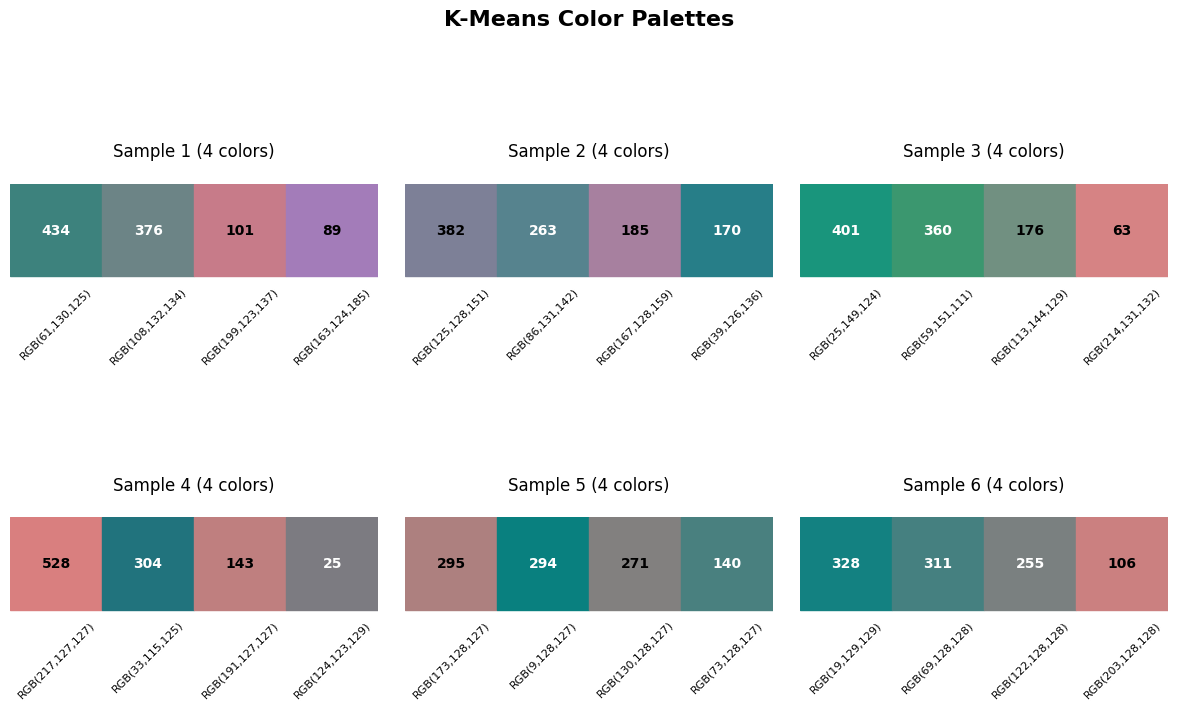


K-Means Palette Summary:

Sample 1:
  Method: centroids
  Total samples: 1000
  Number of colors: 4
  Color breakdown:
    Color 1: (61, 130, 125) (#3d827d) - 434 samples (43.4%)
    Color 2: (108, 132, 134) (#6c8486) - 376 samples (37.6%)
    Color 3: (199, 123, 137) (#c77b89) - 101 samples (10.1%)
    Color 4: (163, 124, 185) (#a37cb9) - 89 samples (8.9%)

Sample 2:
  Method: centroids
  Total samples: 1000
  Number of colors: 4
  Color breakdown:
    Color 1: (125, 128, 151) (#7d8097) - 382 samples (38.2%)
    Color 2: (86, 131, 142) (#56838e) - 263 samples (26.3%)
    Color 3: (167, 128, 159) (#a7809f) - 185 samples (18.5%)
    Color 4: (39, 126, 136) (#277e88) - 170 samples (17.0%)

Sample 3:
  Method: centroids
  Total samples: 1000
  Number of colors: 4
  Color breakdown:
    Color 1: (25, 149, 124) (#19957c) - 401 samples (40.1%)
    Color 2: (59, 151, 111) (#3b976f) - 360 samples (36.0%)
    Color 3: (113, 144, 129) (#719081) - 176 samples (17.6%)
    Color 4: (214, 131, 132)

{0: {'colors_rgb': [(61, 130, 125),
   (108, 132, 134),
   (199, 123, 137),
   (163, 124, 185)],
  'colors_hex': ['#3d827d', '#6c8486', '#c77b89', '#a37cb9'],
  'counts': [434, 376, 101, 89],
  'original_indices': [1, 0, 3, 2],
  'total_samples': 1000,
  'method': 'centroids'},
 1: {'colors_rgb': [(125, 128, 151),
   (86, 131, 142),
   (167, 128, 159),
   (39, 126, 136)],
  'colors_hex': ['#7d8097', '#56838e', '#a7809f', '#277e88'],
  'counts': [382, 263, 185, 170],
  'original_indices': [2, 3, 0, 1],
  'total_samples': 1000,
  'method': 'centroids'},
 2: {'colors_rgb': [(25, 149, 124),
   (59, 151, 111),
   (113, 144, 129),
   (214, 131, 132)],
  'colors_hex': ['#19957c', '#3b976f', '#719081', '#d68384'],
  'counts': [401, 360, 176, 63],
  'original_indices': [0, 3, 2, 1],
  'total_samples': 1000,
  'method': 'centroids'},
 3: {'colors_rgb': [(217, 127, 127),
   (33, 115, 125),
   (191, 127, 127),
   (124, 123, 129)],
  'colors_hex': ['#d97f7f', '#21737d', '#bf7f7f', '#7c7b81'],
  'co

In [243]:
kmeans_results = group_samples_with_kmeans(samples, n_clusters=4)
palette_plot(kmeans_results, model_name="K-Means")